In [1]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

### Helper functions

In [2]:
def read_im(fname, data_path='../RedLights2011_Medium'):
    # read image using PIL:
    I = Image.open(os.path.join(data_path,fname))
    # convert to numpy array:
    return np.asarray(I)


def plot_with_bounding_boxes(I, bboxes, ax=None, l_width=1):
    ''' Helper function that plots image I with bounding boxes'''
    if ax is None:
        ax = plt.subplot(111)
    if isinstance(l_width, (int, float)):
        l_width = [l_width] * len(bboxes)
    
    ax.imshow(I)
    
    for i, bbox in enumerate(bboxes):
        # Create a Rectangle patch
        y1, x1, y2, x2 = bbox
        anchor = (x1, y1)
        width = (x2 - x1)
        height = (y2 - y1)
        rect = patches.Rectangle(anchor, width, height, 
                    linewidth=l_width[i], edgecolor='g', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    return ax

### Finding Red Light examples

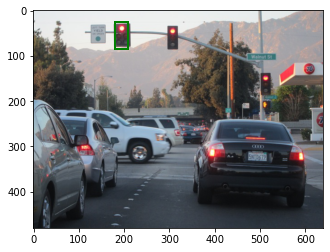

In [3]:
#rl_examples = []

fname = 'RL-012.jpg'
# We want all example boxes to be the same size
# for convenience in averaging, so we specify (30, 60)
# boxes with an anchor point
anchor = (180, 25)
filter_box = [np.arange(30, dtype=int) + anchor[0], 
              np.arange(60, dtype=int) + anchor[1]]

I = read_im(fname)
idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
bbox = [filter_box[1][0], filter_box[0][0],
        filter_box[1][-1], filter_box[0][-1]]
#plt.imshow(I[idx])
plot_with_bounding_boxes(I, [bbox], l_width=2);

#rl_examples += [(fname, filter_box)]
#rl_examples

### Finding non red light examples

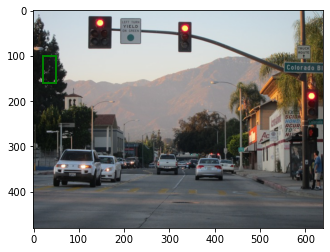

In [4]:
#non_rl_examples = []

fname = 'RL-010.jpg'
# We want all example boxes to be the same size
# for convenience in averaging, so we specify (30, 60)
# boxes with an anchor point
anchor = (20, 100)
filter_box = [np.arange(30, dtype=int) + anchor[0], 
              np.arange(60, dtype=int) + anchor[1]]

I = read_im(fname)
idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
bbox = [filter_box[1][0], filter_box[0][0],
        filter_box[1][-1], filter_box[0][-1]]
#plt.imshow(I[idx])
plot_with_bounding_boxes(I, [bbox], l_width=2);

#non_rl_examples += [(fname, filter_box)]
#non_rl_examples

### Sanity checking examples and pickling

In [5]:
# Sanity check a few examples
#idx = 7
#fname, filter_box = rl_examples[idx]
#I = read_im(fname, data_path=data_path)
#bbox = [filter_box[1][0], filter_box[0][0],
#        filter_box[1][-1], filter_box[0][-1]]
#plot_with_bounding_boxes(I, [bbox], l_width=1);

# Save as pickle
#with open('rl_examples.pkl', 'wb') as f:
#    pickle.dump(rl_examples, f)
#with open('non_rl_examples.pkl', 'wb') as f:
#    pickle.dump(non_rl_examples, f)


### Building a filter

0.8792823599435788
Mean inner product with rl examples:  0.8792823599435787
Mean inner product with non-rl examples:  0.7252627879429018
Visualizing filter


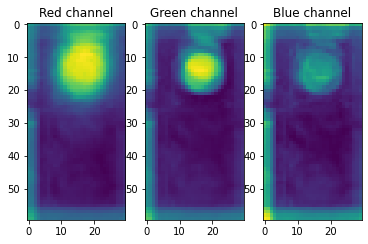

In [6]:
with open('rl_examples.pkl', 'rb') as f:
    rl_examples = pickle.load(f)
with open('non_rl_examples.pkl', 'rb') as f:
    non_rl_examples = pickle.load(f)
    
things_to_av = []
for fname, filter_box in rl_examples:
    I = read_im(fname)
    idx = np.ix_(filter_box[1], filter_box[0], [0, 1, 2])
    things_to_av.append(I[idx] / np.linalg.norm(I[idx]))
    
filt = np.mean(things_to_av, axis=0)
print(np.linalg.norm(filt))
filt /= np.linalg.norm(filt)

Ts = [np.sum(filt * im) for im in things_to_av]
print('Mean inner product with rl examples: ', np.mean(Ts))

non_rl_to_compare = []
for fname, filter_box in non_rl_examples:
    I = read_im(fname)
    idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
    non_rl_to_compare.append(I[idx] / np.linalg.norm(I[idx]))

T2s = [np.sum(filt * im) for im in non_rl_to_compare]
print('Mean inner product with non-rl examples: ', np.mean(T2s))
    
print('Visualizing filter')
fig, axes = plt.subplots(1, 3)
for i in range(3):
    axes[i].imshow(filt[:, :, i])
    axes[i].set_title(['Red', 'Green', 'Blue'][i] + " channel")
    
with open('filter.pkl', 'wb') as f:
    pickle.dump(filt, f)

### Take 1 on detection

In [8]:
from run_predictions import compute_convolution, detect_red_light_mf_v0, detect_red_light_mf

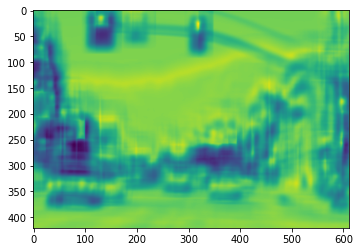

In [20]:
fname = 'RL-010.jpg'
I = read_im(fname)
heatmap,_,_ = compute_convolution(I, filt, transform = lambda x: x / np.linalg.norm(x))
plt.imshow(heatmap)
plt.savefig('heatmap.png')

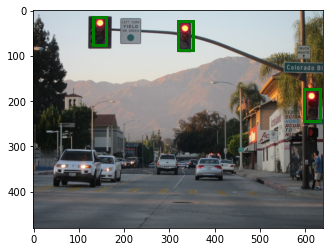

In [29]:
plt.imshow(I)
#bboxes0 = detect_red_light_mf_v0(I)
bboxes1 = detect_red_light_mf(fname)
#bboxes2 = detect_red_light(I)
bboxes = [(a, b, c, d) for (a, b, c, d, s) in bboxes1]
scores = [s for (a, b, c, d, s) in bboxes1]
    
scores = np.array(scores)
scores *= 3

idx = np.argsort(scores)[::-1]
bboxes = np.array(bboxes)[idx]
scores = scores[idx]

# Take only top 3
scores = scores[:3]
bboxes = bboxes[:3]
    
plot_with_bounding_boxes(I, bboxes, ax = plt.gca(), l_width=scores);